<a href="https://colab.research.google.com/github/Nathan2605/linear-regression-project-tutorial/blob/main/Proyecto_regresion_lineal_NH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predecir el coste del seguro médico de una persona

La importante compañía de seguros 4Geeks Insurance S.L. quiere calcular, en función de datos los fisiológicos de sus clientes, cuál va a ser la prima (coste) que debe asumir cada uno de ellos. Para ello, ha reunido a un equipo completo de médicos y en función de datos de otras compañías y un estudio particular han logrado reunir un conjunto de datos para entrenar un modelo predictivo.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, roc_auc_score

## funciones

In [ ]:
def is_binary(df_, nums):
    df = df_.copy()
    variables = []
    for var in nums:
        flag = True
        unique = df_[var].unique()
        for value in unique:
            if value not in [0, 1, np.nan, 0.0, 1.0]:
                flag = False
        if flag == True:
            variables.append(var)
    return variables

In [ ]:
def breakdown_vars(df, off_binary=False):
    """
    This function allow us categorize accodign to numerical or not
    """
    binaries = is_binary(df, df.columns)
    categorial = []
    nonormal = []
    normal = []
    for t in df.columns:
        if off_binary == False:
          if (df[t].dtypes.name=="object" or df[t].dtypes.name=='category') and  t not in binaries:
            categorial.append(t)
        else:
           if (df[t].dtypes.name=="object" or df[t].dtypes.name=='category'):
            categorial.append(t)
        if (df[t].dtypes=="int64" or df[t].dtypes=="float64") and t not in binaries:
                n,p = stats.shapiro(df[t])
                if p<0.05:
                    nonormal.append(t)
                else:
                    normal.append(t)
    if off_binary == False:
      return categorial, binaries, nonormal, normal
    else:
      return categorial, nonormal, normal

## Paso 1: Carga del conjunto de datos

In [ ]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv'

In [ ]:
df = pd.read_csv(url)

## Paso 2: Realiza un EDA completo

In [ ]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [ ]:
#eliminar duplicados
df = df.drop_duplicates().reset_index(drop = True)

In [ ]:
#contemos los Nan
for col in df.columns:
  print(col, df[col].isnull().sum()) #parece que no hay Nan

age 0
sex 0
bmi 0
children 0
smoker 0
region 0
charges 0


**VARIABLES CATEGORICAS**

In [ ]:
#categorizamos las variables
cat, nonormal , normal = breakdown_vars(df, off_binary=True)

In [ ]:
#veamos
print(f'categoricas:{cat}\nnormal: {nonormal}\nnonromal{normal}')

categoricas:['sex', 'smoker', 'region']
normal: ['age', 'bmi', 'children', 'charges']
nonromal[]


(array([ 30., 127., 234., 318., 288., 195.,  96.,  32.,  14.,   3.]),
 array([15.96 , 19.677, 23.394, 27.111, 30.828, 34.545, 38.262, 41.979,
        45.696, 49.413, 53.13 ]),
 <BarContainer object of 10 artists>)

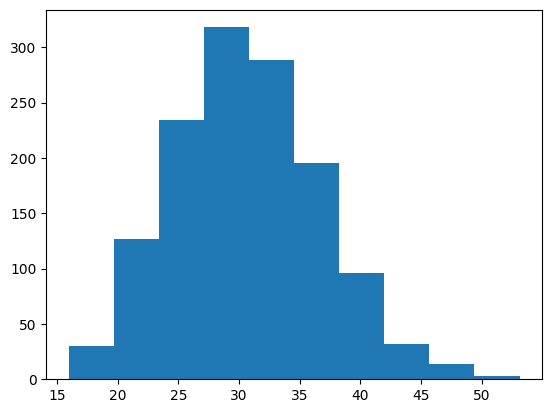

In [ ]:
#veamos
plt.hist(df['bmi'])

In [ ]:
#factorizar todas las categoricas
for col in cat:
  df[col] = pd.factorize(df[col])[0]  #-1 son Nan

In [ ]:
#confirmar, valores unicos de las categoricas
for col in cat:
  print(col, df[col].unique())

sex [0 1]
smoker [0 1]
region [0 1 2 3]


**CORRELACION Y MULTICOLINEALIDAD**

In [ ]:
#checamos correlacion con nuestra variable objetivo
df.corr()

,age,sex,bmi,children,smoker,region,charges
age,1.000000,-0.019814,0.109344,0.041536,0.025587,-0.001626,0.298308
sex,-0.019814,1.000000,0.046397,0.017848,-0.076596,-0.004936,0.058044
bmi,0.109344,0.046397,1.000000,0.012755,-0.003746,-0.157574,0.198401
children,0.041536,0.017848,0.012755,1.000000,-0.007331,-0.016258,0.067389
smoker,0.025587,-0.076596,-0.003746,-0.007331,1.000000,-0.002358,-0.787234
region,-0.001626,-0.004936,-0.157574,-0.016258,-0.002358,1.000000,0.006547
charges,0.298308,0.058044,0.198401,0.067389,-0.787234,0.006547,1.000000


- variables considerables: 'age', 'bmi', 'smoker'
- no tienen mucha correlacion entre si, multicolinealidad ok
-consideramos: 'children'
- eliminamos: 'sex, 'region'

In [ ]:
#opcion guardando children
df2 = df[['age', 'bmi', 'children', 'smoker', 'charges']]

In [ ]:
#opcion eliminar sex, children, region, que no tiene corr con nuestra target
df = df[['age', 'bmi', 'smoker', 'charges']]

In [ ]:
df

,age,bmi,smoker,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,1,4449.46200
3,33,22.705,1,21984.47061
4,32,28.880,1,3866.85520
...,...,...,...,...
1332,50,30.970,1,10600.54830
1333,18,31.920,1,2205.98080
1334,18,36.850,1,1629.83350
1335,21,25.800,1,2007.94500


**TRAIN TEST SPLIT**

In [ ]:
# Separamos las predictoras de la etiqueta
X = df.loc[ : , df.columns != 'charges']
y = df[['charges']]

In [ ]:
# Hacemos el SPLITen train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 666)

## Paso 3: Construye un modelo de regresión lineal

In [ ]:
#definir y entrenar el modelo
mod = smf.ols(formula = 'charges ~ age	+ bmi +	smoker', data=df).fit()

In [ ]:
#imprimir resultado
print(mod.summary())                     #aprox 74.7% de explicacion del modelo

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     1314.
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:18:40   Log-Likelihood:                -13547.
No. Observations:                1337   AIC:                         2.710e+04
Df Residuals:                    1333   BIC:                         2.712e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.215e+04    987.546     12.304      0.0

In [ ]:
#predicciones
y_pred = mod.predict(X_test)
y_pred

,0
1257,14765.487737
1098,5780.707600
794,28350.445858
722,4679.046338
1205,14862.709479
...,...
388,2368.466229
577,32483.926306
160,31628.893210
611,3695.282523


In [ ]:
#probemos INCLUYENDO 'children'

X2 = df2.loc[ : , df2.columns != 'charges']
y2 = df2[['charges']]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, shuffle = True, random_state = 123)

mod2 = smf.ols(formula = 'charges ~ age	+ bmi +	children + smoker', data=df2).fit()
print(mod2.summary())              #75% de explicacion, ganamos 1%

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     996.5
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:18:40   Log-Likelihood:                -13541.
No. Observations:                1337   AIC:                         2.709e+04
Df Residuals:                    1332   BIC:                         2.712e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.171e+04    991.869     11.808      0.0

In [ ]:
#nuevas pred
y_pred = mod2.predict(X_test2)
y_pred

,0
28,-101.350137
547,17798.224895
856,25922.638209
1335,1618.671983
221,12265.339649
...,...
186,5179.593901
866,17132.955879
67,7155.094048
630,3518.538250
